 - Diana Zaray Corado #191025
 - Pablo Alejandro Méndez #19195
- Orlando Osberto Cabrera #19943
# Hoja de Trabajo 7 - Redes Neuronales Artificales  

In [23]:
# Librerias
import pandas as pd
import numpy as np
import scipy.stats as sp
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import mean_squared_error,r2_score, explained_variance_score, mean_absolute_error


In [24]:
# General variables
cuantitative = [
    'LotFrontage',
    'LotArea',
    'MiscVal',
	'WoodDeckSF',
    'OpenPorchSF',
    'EnclosedPorch',
    '3SsnPorch',
    'ScreenPorch',
    'PoolArea',
    'GarageArea',
    'GrLivArea',
    'LowQualFinSF',
    '2ndFlrSF',
    '1stFlrSF',
    'TotalBsmtSF',
    'BsmtUnfSF',
    'BsmtFinSF2',
    'BsmtFinSF1',
    'MasVnrArea',
    'BsmtFullBath',
    'BsmtHalfBath',
    'FullBath',
    'HalfBath',
    'KitchenAbvGr',
    'TotRmsAbvGrd',
    'Fireplaces',
    'GarageCars',
    'SalePrice',
]

# Exploración de los datos
Para el desarrollo de modelos de clasificación y de regresión lineal se cuenta con un conjunto de datos provisto por Kaggle, la cual es una comunidad en línea de científicos de datos, que permite encontrar conjuntos de datos para explorar y construir modelos. El data set a utilizar se conoce como *House Prices: Advance Regression Techniques*, el cual tiene tanto un conjunto de entrenamiento como un conjunto de prueba. En esta hoja se estara utilizando el conjunto de entrenamiento, que cuenta con 81 variables y 1460 observaciones, el cual a su vez un 70% de los datos se utilizará como entrenamiento y un 30% como prueba. 

Se omite el análisis exploratorio del conjunto de datos debido a que ya se ha presentado en hojas de trabajo anteriores 

In [25]:
train = pd.read_csv("./train.csv")
train_shape = train.shape

# Resumen de los datos
head = train.head().style.set_properties(**{'text-align': 'center'}) 
display(head)
del head

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.000000,8450,Pave,nan,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.000000,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,nan,Attchd,2003.000000,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,nan,nan,nan,0,2,2008,WD,Normal,208500
1,2,20,RL,80.000000,9600,Pave,nan,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.000000,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.000000,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,nan,nan,nan,0,5,2007,WD,Normal,181500
2,3,60,RL,68.000000,11250,Pave,nan,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.000000,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.000000,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,nan,nan,nan,0,9,2008,WD,Normal,223500
3,4,70,RL,60.000000,9550,Pave,nan,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.000000,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.000000,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,nan,nan,nan,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.000000,14260,Pave,nan,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.000000,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.000000,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,nan,nan,nan,0,12,2008,WD,Normal,250000


## Preprocesamiento
Para el preprocesamiento de los datos se procede a validar si existen observaciones con valores faltantes y se realiza un escalamentiento de los datos.

In [26]:
select_train = train[cuantitative]
# Asegurando que no existan valores nan o inf
select_train = select_train[~select_train.isin([np.nan, np.inf, -np.inf]).any(1)]

Por análisis realizados en hojas anteriores se sabe que los datos no siguen una distribución normal, por lo tal es necesario realizar una normalización o una estandarización para garantizar que ninguna variable que tenga rango de valores muy grandes sean más influeyentes en el modelo que aquellas con rango de valores más bajos. Sin embargo, para poder agregar la variable clasificadora, la estandarización se realizará antes de hacer la separación de los conjuntos de datos en entrenamiento y prueba. 

Si bien es muy común que al momento de hacer preprocesamiento de los datos se realice tratamiento de outliers, las redes neuronales, especialmente aquellas que son multicapa, debido a que es un proceso de varios pasos para hacer el *fit* a los datos, esto abre paso a que el modelo sea más flexible y disminuya el impacto de los outliers. Por otro lado, generalmente las funciones de activación, proveen una especia de "aplanamiento" lo cual le da la capacidad al modelo de tratar los *outliers* y de que estos no tengan un impacto significativo en el modelo. 

Por lo mencionado anteriormente, no se realizará ningún tipo de tratamiento de *outliers* además de para garantizar una comparación equitativa con los modelos realizados en otras hojas de trabajo.

## Conjunto de prueba y entrenamiento
Seleccione como variable respuesta la que creó con las categorías del precio de la casa.

### Agregando la variable objetivo al conjunto de datos
Debido a que la variable objetivo es categórica y las redes neuronales requieren que los datos sean numéricos, es necesario codificar las categorías mediante números. Para codificar las categorías se usaran los siguientes valores:
- Baratas: 1
- Intermedias: 10
- Caras: 100

In [27]:
# Agregando la nueva variable al data frame
conditions = [
    (select_train['SalePrice'] <= 171500),
    (select_train['SalePrice'] > 171500) & (select_train['SalePrice'] <= 295500),
    (select_train['SalePrice'] > 295500) 
    ]

values = [1, 10, 100]

select_train['HouseCategory'] = np.select(conditions, values)
del values, conditions

### Selección de variables
Para seleccionar las variables a utilizar dentro del modelo, se inició tomando en consideración únicamente las variables numéricas. Seguido a esto, se realizó una correlación entre todas las variables cuantitativas para poder analizar cuáles son las que influyen significativamente en el precio de venta y con base a esto se seleccionó el conjunto de *features* a utilizar.

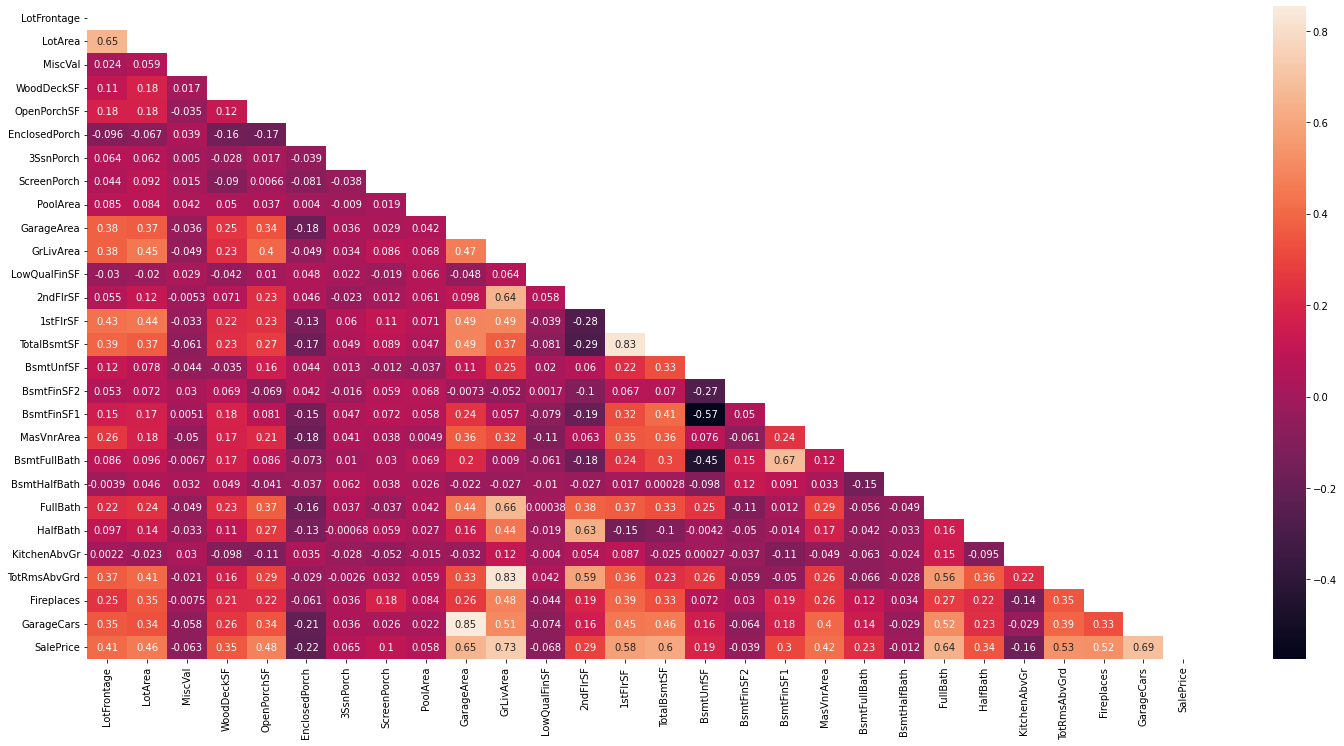

In [28]:
cuantitative_data = train[cuantitative]
correlation = cuantitative_data.corr(method = 'spearman')
plt.figure(figsize=(25,12))
matrix = np.triu(correlation)
sns.heatmap(correlation, annot=True, mask=matrix)
plt.show()

del correlation, cuantitative_data, matrix

Como se puede observar en la tabla y gráfica anterior se presentan aquellas variables que cuentan con una alta correlación (tomando como correlación alta a valores mayores o iguales a 0.5). A continuación se listan la correlaciones encontradas por variables:
- LotFrontage → LotArea
- GarageArea → GarageCars, SalePrice
- GrLivArea → 2ndFlrSF, FullBath, TotRmsAbvGrd, GarageCars, SalePrice
- 2ndFlrSF → HalfBath, TotRmsAbvGrd
- 1stFlrSF → TotalBsmtSF, SalePrice
- TotalBsmtSF → SalePrice
- BsmtUnfSF → BsmtFinSF1, BsmtFullBath
- FullBath → TotRmsAbvGrd, GarageCars, SalePrice
- TotRmsAbvGrd → SalePrice
- Fireplaces → SalePrice
- GargeCars → SalePrice

La estrecha correlación con la que cuentan las variables entre sí representa un potencial error para el modelo, ya que como bien se sabe, uno de los supuestos dentro del modelo de regresión logísticas es que las variables no presenten multicolinealidad ya que esto podría sesgar dicho modelo a la información "repetida" presentada por estas variables. Por lo tal, para evitar un sesgo y *overfitting* del modelo se eliminaran las variables correlacionadas, dejando solo una que represente la información de todas dentro del modelo. Las variables que se descartarán del modelo son:
- LotFrontage
- GarageCars
- TotRmsAbvGrd
- FullBath
- HalfBath
- TotalBsmtSF
- BsmtFinSF1
- BsmFullBath
- Fireplaces

In [29]:
useless = ['LotFrontage', 
'GarageCars', 
'TotRmsAbvGrd', 
'FullBath', 
'HalfBath', 
'TotalBsmtSF', 
'BsmtFinSF1', 
'BsmtFullBath', 
'Fireplaces', 
'PoolArea', 
'LowQualFinSF', 
'BsmtFinSF2', 
'BsmtHalfBath', 
'KitchenAbvGr' ]

In [30]:
selected_train = select_train.loc[:, ~select_train.columns.isin(useless)]

In [31]:
# separate between target and predictors
target = selected_train.pop('HouseCategory')
predictors = selected_train.copy()

In [32]:
# stratified sample
predictors_train, predictors_test, target_train, target_test = train_test_split(predictors, target, train_size  = 0.7, shuffle = True, random_state=19195)

# Clasificación
Genere dos modelos de redes neuronales que sea capaz de clasificar usando la variable respuesta que categoriza las casas en baratas, medias y caras. Estos modelos deben tener diferentes topologías y funciones de activación.

Para el primer modelo de redes neuronales se utilizaran 2 capas, la primera con 3 neuronas y la segunda con 7 neuronas, con una función de activación *hyperbolic tangent* y con un *solver adam* para la optimización de los pesos.

In [33]:
# n general, we recommend using StandardScaler within a Pipeline in order to prevent most risks of data leaking
ht_model = make_pipeline(StandardScaler(), MLPClassifier(hidden_layer_sizes=(3,5), activation='tanh', solver='adam', max_iter=1000, random_state=191943))
ht_model.fit(predictors_train, target_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('mlpclassifier',
                 MLPClassifier(activation='tanh', hidden_layer_sizes=(3, 5),
                               max_iter=1000, random_state=191943))])

Para el segundo modelo de redes neuronales se utilizaran 3 capas, la primera con 3 neuronas, la segunda con 5 y la tercera con 7 neuronas, con una función de activación *ReLU (Rectified Linear Unit)* y con un *solver lbfgs* para la optimización de los pesos.

In [34]:
# n general, we recommend using StandardScaler within a Pipeline in order to prevent most risks of data leaking
relu_model = make_pipeline(StandardScaler(), MLPClassifier(hidden_layer_sizes=(3,5, 7), activation='relu', solver='lbfgs', max_iter=700, random_state=191943))
relu_model.fit(predictors_train, target_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('mlpclassifier',
                 MLPClassifier(hidden_layer_sizes=(3, 5, 7), max_iter=700,
                               random_state=191943, solver='lbfgs'))])

## Efectividad del modelo para predecir
Use los modelos para predecir el valor de la variable respuesta. Haga las matrices de confusión respectivas.

In [35]:
target_names = ['Barata', 'Intermedia', 'Cara']

In [36]:
# Predicción con modelo con función de activación tangente hiperbólica
prediction_ht_test = ht_model.predict(predictors_test)

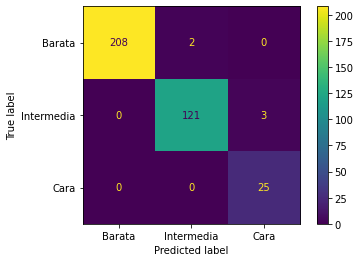

In [37]:
cm = confusion_matrix(target_test, prediction_ht_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
disp.plot()
plt.show()

del cm, disp

Como se puede observar en la matriz de confusión, en general, el modelo es bastante bueno al hacer la clasificación de los datos, ya que únicamente hizo una clasificación incorrecta 5 veces. Lo interesante a notar es que hizo una clasificación perfecta de las casas tipo caras, ya que todas las casas clasificadas como caras el modelo predijo que eran caras. Por otro lado, las casas intermedias son las que el modelo clasificó de manera más incorrecta, clasificando 3 casas intermedias como caras, luego le siguen baratas, de las cuales, 2 clasificó incorrectamente como intermedias. Como bien se sabe, estos errores están asociados a la precición y el *recall* del modelo, al ser la cantidad de errores muy pequeña relativa a la cantidad de aciertos se puede decir que el modelo fue preciso en la clasificación de cada una de las categorías.

In [38]:
# Predicción con modelo con función de activación ReLU
prediction_relu_test = relu_model.predict(predictors_test)

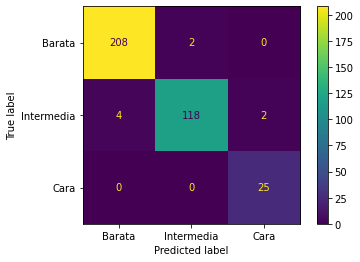

In [39]:
cm = confusion_matrix(target_test, prediction_relu_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
disp.plot()
plt.show()

del cm, disp

Como se puede notar en la matriz de clasificación, al igual que el modelo anterior, la categoría de casas caras fue clasificada de manera perfecta, y en general se puede observar que el modelo predice de manera muy acertada las categorías a las cuales pertenecen las observaciones. En este caso se puede observar que de las casas clasificadas como intermedias, aproximadamente un 3% fue predicha de manera incorrecta, de esto, un 2% se clasificó como casas baratas y un 1% como casas caras. Por otro lado, también se tiene que de todas las casas  baratas en el data set, aproximadamente un 2% no se predijo correctamente, ya que 3 casas caras, se predijeron como intermedias. 

Si bien como se mencionó al inicio, todas las casas clasificadas como caras el momento supo predecirlas, el modelo además predijo de forma incorrecta una casa extra como cara siendo esta intermedia. 

## Efectividad entre los modelos de redes neuronales
Compare los resultados obtenidos con los diferentes modelos de clasificación usando redes neuronales en cuanto a efectividad, tiempo de procesamiento y equivocaciones (donde el algoritmo se equivocó más, donde se equivocó menos y la importancia que tienen los errores).

In [40]:
print(classification_report(target_test, prediction_ht_test, target_names=target_names))
print('Optimización alcanzada de la función de pérdida:', ht_model.named_steps['mlpclassifier'].loss_)

              precision    recall  f1-score   support

      Barata       1.00      0.99      1.00       210
  Intermedia       0.98      0.98      0.98       124
        Cara       0.89      1.00      0.94        25

    accuracy                           0.99       359
   macro avg       0.96      0.99      0.97       359
weighted avg       0.99      0.99      0.99       359

Optimización alcanzada de la función de pérdida: 0.020624300128292906


In [41]:
print(classification_report(target_test, prediction_relu_test, target_names=target_names))
print('Optimización alcanzada de la función de pérdida:', relu_model.named_steps['mlpclassifier'].loss_)

              precision    recall  f1-score   support

      Barata       0.98      0.99      0.99       210
  Intermedia       0.98      0.95      0.97       124
        Cara       0.93      1.00      0.96        25

    accuracy                           0.98       359
   macro avg       0.96      0.98      0.97       359
weighted avg       0.98      0.98      0.98       359

Optimización alcanzada de la función de pérdida: 4.9795240404856815e-05


Al comparar los tiempos de ejecución de cada uno de los modelos se puede notar que el modelo con la función de activación hiperbólica tangencial tardo aproximadamente 2s y el modelo con la función de activación ReLU tardó apriximadamente 315ms. Es interesante notar, además de que la diferencia de tiempo de ejecución de ambos modelos es significativa, que el modelo que tiene menor cantidad de capas ocultas es el que se tarda más. Esto se podría explicar por la función de optimización utilizada para la asignación de los pesos, ya que en el caso de el modelo con función de activación hipérbolica, se utlizó el *solver adam* el cual para conjuntos de datos relativamente largos trabaja bastante rápido, sin embargo, si el conjunto de datos es pequeño, el *solver lbfgs* converge de manera más rápida con un mejor performance. Esto también se puede notar en la cantidad máxima de iteraciones de cada modelo, ya que para el primero fue necesario un máximo de 1000 iteraciones para que pudiera converger, a diferencia del segundo, que con 700 iteraciones máximas alcanzó a converger. 

Por otro lado, si se toma como medida de efectividad o de comparación entre los modelos el valor de *accuracy* el modelo 1 es el mejor modelo, ya que como se puede observar el modelo 1 obtuvo un *accuracy* de 99% en comparación con el modelo 2, el cual obtuvo un *accuracy* de 98%, sin embargo, como ya se ha mencionado anteriormente el valor de *accuracy* no siempre suele ser una buena opción para la comparación entre modelos, en especial si se cuenta con un conjunto de datos desbalanceado, por lo tal, si se utliza el *f1-score macro* se tiene que el mejor modelo es el modelo 2, con un *macro avg* de 98% en comparación con un 97% del modelo 1.  

Los errores encontrados en las matrices de clasificación mostradas anteriormente, a parte de permitir al modelo ir aprendiendo, también permiten establecer un punto de optimización del problema que se haya planteado. Ya que los errores permiten observar si el modelo, además de estar haciendo clasificación muy exactas o *accurate* permite también ver la cantidad de falsos positivos y negativos que el modelo esté haciendo. Estos errores permiten analizar y guiar al algoritmo para que se optimice de acorde a la métrica que más se ajusta a los requisitos del problema.

Como bien se mencionó en el apartado anterior, las equivocaciones del modelo están relacionadas con la precisión y la sensibilidad del mismo, en los reportes de clasificación se puede observar, como a pesar de que al clasificar las casas caras el algoritmo es bastante "sensible" o certero, no cuenta con una precisión de 1 debido a que tiene predicciones falsas positivas (las casas clasificadas como caras que no son caras). Por lo tal, la comparación y sobre todo la decisión de escoger el mejor algoritmo de clasificación depende del problema que se busca resolver o cuál es la métrica que se desea optimizar en las predicciones. Sin embargo, en el caso de redes neuronales y en la mayoría de algoritos de predicción, como bien se sabe, el objetivo principal es la optimización de una función de pérdida, la cual, en este contexto, puede establecer otra métrica u otro criterio para la decisión del mejor modelo, en este caso, el modelo 1 obtuvo una optimización final de 0.206 comparado con el modelo 2 el cual obtuvo una optimización final de 5.05-e05. Si bien el modelo 2 alcanzó una optimización mayor, es decir redujo más el error, esto podría representar un *overfitting* de los datos, ya que la función se está ajustando tanto a los datos de entrenamiento que pueda ser que en un futuro no sea capaz de clasificar nuevos datos. Por lo ta, se escoge como mejor modelo, en función de la optimización alcanzada y la capacidad de poder predecir con el menor número de falsos negativos como el modelo 1, o el modelo que usó la función de activació hiperbólica.  

## Comparación con los modelos de clasificación elaborados en hojas de trabajo anteriores
Compare los resultados del mejor modelo de esta hoja para clasificar con los resultados de los algoritmos usados para clasificar de las hojas de trabajo anteriores

En comparación con los modelos de hojas de trabajo anteriores, sin duda alguna el modelo elborado con redes neuronales es uno de los mejores. Ya que ha sido uno de los que mejor ha logrado hacer la predicción de las categorías de las casas. Sin embargo, de todos los modelos desarrollados el mejor fue el trabajado con árboles de decisión, ya que acertó correctamente TODAS las categorias de las observaciones ingresadas. El modelo de árboles de decisión, al realizar su matriz de confusión evidenció que no cometió ningún error al momento de realizar las predicciones de la categorización, a diferencia del de redes neuronales, el cual sí presenta falsos positivos y falsos negativos al momento de hacer las predicciones de los datos. 

Por otro lado, también se han realizado modelos con regresiones y *support vector machines* en ambos casos no se obtuvieron resultados tan óptimos como con redes neuronales o árboles de decisión, sin embargo, hay que tomar en cuenta que en estos casos, es necesaria una prueba de parámetros que permita ir modificando el modelo a medida de que se ajuste lo mejor posible a los datos. Es por ello, que si bien, en este caso el modelo de redes neuronales fue el mejor prediciendo al conjunto de datos provisto, ya que en el caso de regresión logística el modelo se equivocaba demasiado, principalmente al hacer la predicción de casas intermedias y por otro lado, en el caso de *support vector machines* si bien, en cuestión de exactitud, el modelo alcanzó un valor de 93% este aún es más bajo que el alcanzado por las redes neuronales. 

Algo que si es importante a tomar en cuenta es que si bien el modelo de árboles de decisión fue el mejor modelo desarrollado, el resto de modelos trabajados se pueden mejorar y conseguir los parámetros óptimos mediante una validación cruzada y así garantizar el mejor *fit* a los datos y con ello obtener mejores predicciones. Por otro lado, también los modelos, como *support vector machines* son muchos más rápidos que las redes neuronales y que los árboles de decisión. Por lo que si bien, en cuanto a efectividad el de árboles de decisión y las redes neuronales son bastante óptimo, es cuanto a tiempo no, y en este caso eso no representa un problema significativo, pero es algo que se debe de tomar en cuenta en el caso que el conjunto de datos sea muy grande.

Al comparar los modelos se puede ver como algunos de ellos han sido bastante eficientes al momento de hacer la predicción de los tipos de casas, y otros han sido más óptimo en el tiempo que toma desarrollar el modelo. En todos los casos, los modelos es posible mejorarlos mediante la prueba de diferentes combinaciones de parámetros que permitan que el modelo haga un mejor ajuste de los datos, por lo que, si bien, en este caso particular, el modelo de árboles de decisión fue el mejor, eso no implica que los otros modelos no puedan llegar a ser igual de buenos. 

En el caso de las redes neuronales, se pudo observar que con diferentes combianciones de parámetros se obtenían diferentes resultados, y a medida que se agregaban más capas con mayor cantidad de neuronas, sí se lograba una mejor predicción, pero se corría el riesgo de que dicho modelo sufriera de *overfitting*, lo cual es algo a favor de los árboles de decisión, ya que estos, por su estructura, son menos propensos a sufrir *overfitting* además de ser menos influenciados por los *outliers*.

# Regresión
Genere dos modelos de regresión con redes neuronales con diferentes topologías y funciones de activación para predecir el precio de las casas.

Antes de inicar a elaborar los modelos de regresión, primero es necesario modificar los datos de entrenamiento y prueba para que ahora la variable objetivo sea el precio de las casas. 

In [42]:
# Nuevos conjunto de prueba y entrenamiento
target = selected_train.pop('SalePrice')
predictors = selected_train.copy()

In [43]:
predictors_train, predictors_test, target_train, target_test = train_test_split(predictors, target, train_size  = 0.7, shuffle = True, random_state=19195)

El primer modelo de regresión a elaborar por medio de redes neuronales, se utilizaran 3 capas, la primera con 16 neuronas, la segunda con 8 y la última con 10 neuronas, con una función de activación *ReLu* y con un *solver adam* para la optimización de los pesos.

In [44]:
adam_rg_model =MLPRegressor(hidden_layer_sizes=(16, 8, 10), activation='relu', solver='adam', max_iter=2000, random_state=123)
adam_rg_model.fit(predictors_train, target_train)

MLPRegressor(hidden_layer_sizes=(16, 8, 10), max_iter=2000, random_state=123)

En el segundo modelo de regresión a elaborar por medio de redes neuronales, se utilizaran 5 capas, la primera con 9 neuronas, la segunda con 12, la tercera con 12, la cuarta con 4 y la última con 8 neuronas, con una función de activación *ReLu* y con un *solver lbfgs* para la optimización de los pesos.

In [45]:
lbfgs_rg_model =MLPRegressor(hidden_layer_sizes=(9, 12, 12, 4, 8), activation='relu', solver='lbfgs', max_iter=1000, random_state=123456)
lbfgs_rg_model.fit(predictors_train, target_train)

MLPRegressor(hidden_layer_sizes=(9, 12, 12, 4, 8), max_iter=1000,
             random_state=123456, solver='lbfgs')

## Efectividad entre modelos de redes neuronales
Compare los dos modelos de regresión y determine cuál funcionó mejor para predecir el precio de las casas.

In [46]:
prediction_adam = adam_rg_model.predict(predictors_test)
residuos_adam   = prediction_adam - target_test

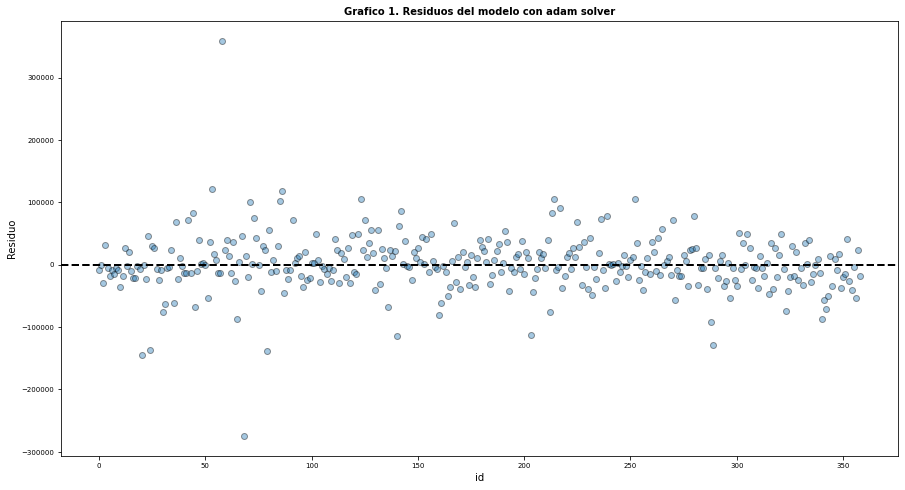

In [47]:
# Extraído de: https://www.cienciadedatos.net/documentos/py10-regresion-lineal-python.html

plt.figure(figsize=(15, 8))

# Residuos Modelo 1
plt.scatter(list(range(len(prediction_adam))), residuos_adam,edgecolors=(0, 0, 0), alpha = 0.4)
plt.axhline(y = 0, linestyle = '--', color = 'black', lw=2)
plt.title('Grafico 1. Residuos del modelo con adam solver', fontsize = 10, fontweight = "bold")
plt.xlabel('id')
plt.ylabel('Residuo')
plt.tick_params(labelsize = 7)

In [48]:
# Métricas para la evaluación del modelo
print ("Variance Score:",explained_variance_score(target_test, prediction_adam))
print ("Mean Absolute Error:", mean_absolute_error(target_test, prediction_adam))

Variance Score: 0.6409220651068002
Mean Absolute Error: 30100.876149879856


Como se puede observar en el **gráfico 1** la distribución de los residuos no presenta un patrón específico, sino más bien, parecen estar  distribuídos aleatoriamente alrededor del 0. Esto indica que el modelo no se encuentra sesgado por ninguna características de los datos, por lo tal, asegura el uso de métricas de evaluación del *performance* del modelo, además de garantizar que el modelo no falla al explicar las propiedades de los datos. 

Como bien se puede observar en las métricas para evaluar el modelo, se tiene el *variance score* la cual explica la dispersión de los errores de las predicciones, básicamente explica la variabilidad de las predicciones del modelo, se sabe que un modelo debe de tener al menos un 60% de *explained variance* para que se considere un buen modelo, como se puede notar en este caso, el valor de *explained variance* del modelo es de 65%, es decir, en un 65% la varianza del modelo es explicada por características de los datos, indicando así una asociación fuerte entre las variable obejtivo y los predictores.

Finalmente se tiene la métrica del error absoluto, como bien lo dice el nombre, esta métrica define el promedio entre los residuos absolutos de los datos y además es una métrica menos sensible a los valores atípicos a diferencia de el error cuadráctico medio. Como se puede nota el valor del error es de 30100, este es un error nada cercano al ideal, el cual sería 0, lo que indica de hecho que le modelo no es tan bueno prediciendo los precios de las casas (cosa que también se puede observar en la **gráfica 1**).

Algo interesante es que en busca de mejorar el modelo se opto por utilizar un mayor cantidad de *features* sin emabrgo, cuando se hizo esto lo que pasó es que las predicciones se encontraban aún mucho más alejadas del valor real. Por lo tal, y para que posteriormente se pudiera hacer una comparación justa con los otros modelos desarrollados a lo largo del curso, se utilizaron únicamente los *features* definidos en apartados anteriores. 

In [49]:
prediction_lbfsg = lbfgs_rg_model.predict(predictors_test)
residuos_lbfsg   = prediction_lbfsg - target_test

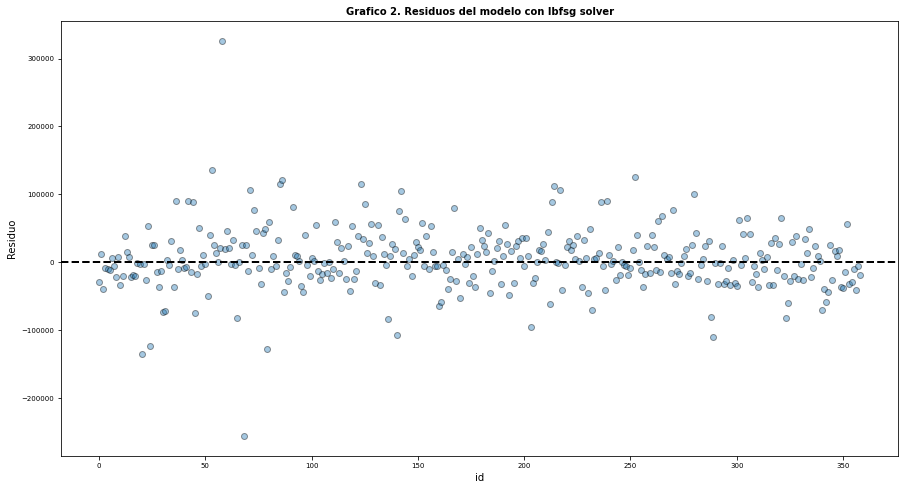

In [50]:
# Extraído de: https://www.cienciadedatos.net/documentos/py10-regresion-lineal-python.html

plt.figure(figsize=(15, 8))

# Residuos Modelo 1
plt.scatter(list(range(len(prediction_lbfsg))), residuos_lbfsg,edgecolors=(0, 0, 0), alpha = 0.4)
plt.axhline(y = 0, linestyle = '--', color = 'black', lw=2)
plt.title('Grafico 2. Residuos del modelo con lbfsg solver', fontsize = 10, fontweight = "bold")
plt.xlabel('id')
plt.ylabel('Residuo')
plt.tick_params(labelsize = 7)

In [51]:
# Métricas para la evaluación del modelo
print ("R^2:",r2_score(target_test, prediction_lbfsg))
print ("Variance Score:",explained_variance_score(target_test, prediction_lbfsg))
print ("Mean Absolute Error:", mean_absolute_error(target_test, prediction_lbfsg))

R^2: 0.6308843478336398
Variance Score: 0.6342153598152638
Mean Absolute Error: 31687.08089902768


Al igual que con el modelo 1, como se puede observar en el **gráfico 2** la distribución de los residuos no presenta ningún patrón específico, permitiendo así asegurar que los datos no están sesgados con respecto a ninguna característica de los datos, esto asegura también el poder utilizar las diferentes métricas para evaluar la calidad del modelo.

Como se puede notar en este caso, el valor de *explained variance* del modelo es de 63%, es decir, en un 63% la varianza del modelo es explicada por características de los datos, indicando así una asociación fuerte entre las variable obejtivo y los predictores. Como bien se mencionó anteriormente para que un modelo se considere bueno, es necesario que al menos tenga 60% de *explained variance*, entonces en este caso, se asegura que sí existe una fuerte asociación entre la variable objetivo y sus predictores.

Finalmente se tiene la métrica del error absoluto, como bien lo dice el nombre, esta métrica define el promedio entre los residuos absolutos de los datos. Como se observa el valor del error es de 30879, que si bien este es un error nada cercano al ideal, el cual sería 0, es uno de los mejores errores recibidos en los modelos de regresión elaborados a lo largo del curso. No podemos asegurar que sea un buen modelo, ya que el error en las predicciones de los precios es bastante grande, sin embargo, dependiendo del contexto del problema este modelo podría ser útil. 

Algo que es necesario recalcar es que una de las principales diferencias entre este modelo y el anterior es el optimizador de pesos que se está utilizando, y si bien en este caso, el modelo es mucho más rápido, en el caso anterior, el modelo es un poco más certero respecto con este. 

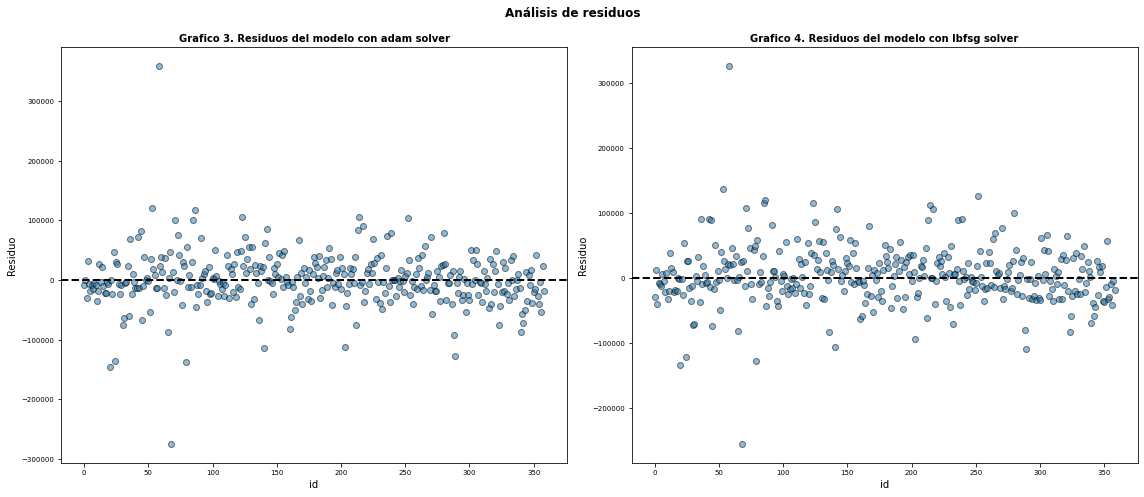

In [52]:
# Extraído de: https://www.cienciadedatos.net/documentos/py10-regresion-lineal-python.html

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16,7))

# Residuos
axes[0].scatter(list(range(len(prediction_adam))), residuos_adam,edgecolors=(0, 0, 0), alpha = 0.5)
axes[0].axhline(y = 0, linestyle = '--', color = 'black', lw=2)
axes[0].set_title('Grafico 3. Residuos del modelo con adam solver', fontsize = 10, fontweight = "bold")
axes[0].set_xlabel('id')
axes[0].set_ylabel('Residuo')
axes[0].tick_params(labelsize = 7)

# Residuos lbfsg
axes[1].scatter(list(range(len(prediction_lbfsg))), residuos_lbfsg,edgecolors=(0, 0, 0), alpha = 0.5)
axes[1].axhline(y = 0, linestyle = '--', color = 'black', lw=2)
axes[1].set_title('Grafico 4. Residuos del modelo con lbfsg solver', fontsize = 10, fontweight = "bold")
axes[1].set_xlabel('id')
axes[1].set_ylabel('Residuo')
axes[1].tick_params(labelsize = 7)

fig.tight_layout()
plt.subplots_adjust(top=0.9)
fig.suptitle('Análisis de residuos', fontsize = 12, fontweight = "bold");

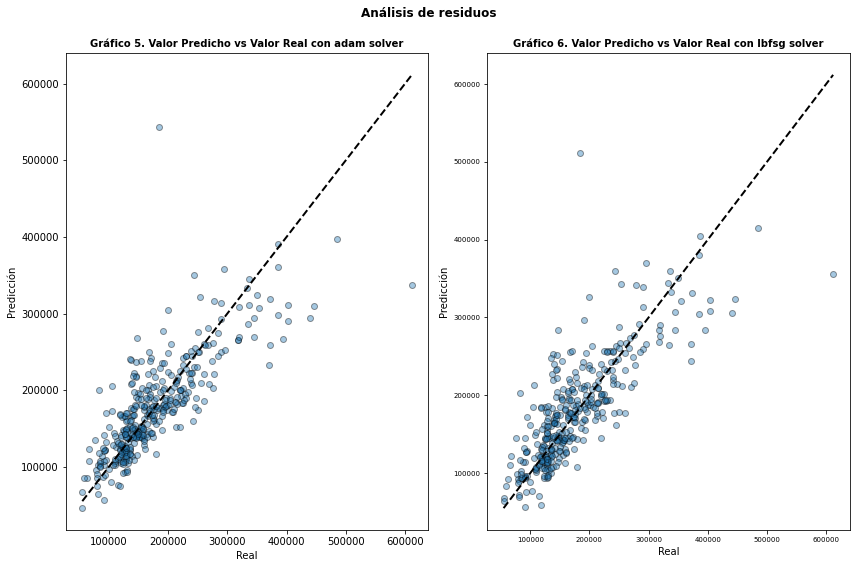

In [53]:
# Extraído de: https://www.cienciadedatos.net/documentos/py10-regresion-lineal-python.html

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,8))

# Comparación entre valores predichos y valores reales
axes[0].scatter(target_test, prediction_adam, edgecolors=(0, 0, 0), alpha = 0.4)
axes[0].plot([target_test.min(), target_test.max()], [target_test.min(), target_test.max()], 'k--', lw=2)
axes[0].set_title('Gráfico 5. Valor Predicho vs Valor Real con adam solver', fontsize = 10, fontweight = "bold")
axes[0].set_xlabel('Real')
axes[0].set_ylabel('Predicción')
plt.tick_params(labelsize = 7)

# Comparación entre valores predichos y valores reales
axes[1].scatter(target_test, prediction_lbfsg, edgecolors=(0, 0, 0), alpha = 0.4)
axes[1].plot([target_test.min(), target_test.max()], [target_test.min(), target_test.max()], 'k--', lw=2)
axes[1].set_title('Gráfico 6. Valor Predicho vs Valor Real con lbfsg solver', fontsize = 10, fontweight = "bold")
axes[1].set_xlabel('Real')
axes[1].set_ylabel('Predicción')
plt.tick_params(labelsize = 7)

fig.tight_layout()
plt.subplots_adjust(top=0.9)
fig.suptitle('Análisis de residuos', fontsize = 12, fontweight = "bold");

Como se puede notar en las gráficas anteriormente, los valore predichos por el modelo desarrollado con el *solver adam* se encuentran más cercanos al ideal o a la línea punteada en comparación con los valores predichos por el otro modelo desarrollado, de igual forma, se puede notar que en donde se encuentra la mayor concentración de puntos, la separación de los valores predichos sobreestimados con respecto al ideal es menor en el **gráfico 5** que en el **gráfico 6**, por otro lado, una similitud que se puede notar es que en ambos modelos es posible observar que existen 3 valores atípicos que se encuentran muy alejados de donde se encuentra la mayor concentración de puntos. Las diferencias en los gráficos también se pueden observar en los valores de error obtenidos en ambos modelos, ya que el modelo desarrollado con *solver adam* retorno un error medio absoluto de 30100 a diferencia del modelo con el *solver lbfgs* el cual tiene un error de 30879. Si bien se podría considerar que la diferencia es mínima e insignificante, en los gráficos, tanto de los residuos como de los valores predichos y reales, se puede observar que la diferencia sí es significativa, ya que en el caso del modelo 2 los valores tienden a alejarse más del ideal comparado con los valores predichos por el modelo 1. 

Con base en lo anteriormente mencionado, y también en los gráficos desarrollados para el análisis de la eficiencia de los modelos se escoge como el mejor modelo a aquel que se desarrollo con 3 capas ocultas y el optimizador *adam*.

Por otro lado, en busca de mejorar ambos modelos se probaron distintas funciones de activación, sin embargo, el resto de funciones de activación disponibles en la librería utilizada, son más que todo utilizadas para clasificación, ya que el valor retornado, se define como falso, si la función de activación retorna 0 y verdadero si la función de activación retorna 1. Por lo tal, se utilizó la función de activació que permitía obtener residuos más bajos. 

Debido a que la función de activación no cambia en ninguno de los modelos, se decidió cambiar la función de optimización de los pesos, como se mencionó anteriormente, el *solver adam* es más robusto y utilzado principalmente para grandes conjuntos de datos, y el *lbfsg* es más rápido y utilizado para conjuntos de datos pequeños. Debido a esto, se puede explicar que el primer modelo (con *solver adam*) a pesar de tener menos capas ocultas que el segundo modelo (con el *solver lbfsg*) es más lento. Además, para buscar que el modelo se pudiera ajustar de mejor forma a los datos, se decidió jugar un poco con la cantidad de neuronas y capas en cada modelo, sin embargo, si se aumentaba la cantidad de capas, el modelo solo se tardaba un poco más en terminar y los resultados de las métricas eran las mismas, y lo mismo pasaba si se modificaba la cantidad de neuronas en cada modelo. Si bien esta no fue la forma eficiente de realizar este proceso, una recomendación para el futuro es poder utilizar validación cruzada, para evitar que el modelo se encuentre sesgado a alguna características de los datos y además para poder encontrar los valores óptimos de capas y redes que permitan minimizar el error al máximo.

## Efectividad con los modelos de regresión elaborados anteriormente
Compare la eficiencia del mejor modelo de RNA con los resultados obtenidos con los algoritmos de las hojas de trabajo anteriores. ¿Cuál es mejor para predecir? ¿Cuál se demoró más en procesar?

En todos los modelos de regresión elaborados a lo largo del curso, no se pudo desarrollar uno que pudiera retornar un error medio absoluto por debajo de 30000, lo cual en sí indica que todos los modelos que se desarrollaron no son muy buenos al momento de hacer las predicciones de los precios de las casas. Sin embargo, al comparar entre ellos se encuentra que el modelo desarrollado con redes neuronales y con un *solver adam* presentó en promedio el menor error absoluto de todos, siendo este de 30100, por lo que con base a esta métrica se podría decir que este es mejor para predecir. 

Por otro lado, si se comparan los modelos en cuanto a tiempo de ejecución, en este caso el modelo más rápido fue el desarrollado mediante la regresión lineal, e incluso una de las ventajas principales de los modelos desarrollados por regresión lineal es que suelen ser bastante rápidos cuando existe un conjunto muy grande de datos. 

Si bien, entre todos los modelos desarrollados el mejor fue el que se hizo mediante redes neuronales, este también a su vez es uno de los más lentos en cuanto a tiempo de procesamiento. Por otro lado, si bien el modelo elaborado mediante regresión lineal, es el más alejado de predecir el valor certero a los precios de las casas, al comparar la predicción de los precios con respecto a los valores reales, a diferencia del modelo de redes neuronales, parece ser que el modelo de regresión lineal, luego de cierto valor, sus predicciones se encuentran por debajo de del valor ideal, lo que podría establecer una especie de valor mínimo en el precio de las casas. 

Si bien, de acorde a criterios de métricas, el mejor modelo se puede definir como el que se desarrolló con redes neuronales, es importante resaltar que el mejor modelo depende del contexto de la problemática, ya que independientemente que todos los modelos desarrollados tengan residuos altos, cada modelo también proporciona caracterísitica y brinda, además, información valiosa y diferente. 

## Comparación de resultados
Compare los resultados del mejor modelo para predecir el precio de venta con los resultados de los algoritmos usados para el mismo propósito de las hojas de trabajo anteriores.

In [54]:
data = pd.DataFrame({
    'Predicted': prediction_adam,
    'Real': target_test
})

head = data.head(15).style.set_properties(**{'text-align': 'center'}) 
display(head)
del head, data

,Predicted,Real
675,139705.618306,148500
142,166131.937160,166000
1019,183926.423184,213490
193,161497.778389,130000
1218,74519.791592,80500
493,137153.338871,155000
483,155376.278701,164000
1020,160915.677708,176000
599,145427.929320,151000
554,275121.420166,284000


Como se mencionó anterior mente, el modelo que obtuvo mejores valores predichos fue el de *solver adam*, por lo que se usará este para realizar la comparación con los otros modelos de las hojas de trabajo pasadas. 

Al comparar el error medio que se obtuvo con árboles de decisión y con los modelos de regresión, el modelo de red neuronal obtuvo un error menor al de los otros dos. Esto a simple vista puede significar que usar redes neuronales es mejor opción a la hora de realizar predicciones, pero hay que tener en cuenta que este modelo depende más en la cantidad de datos que se utilicen para entrenar al modelo que los otros dos modelos. 

Algo interesante a tomar en cuenta es que en los tres modelos que se han utilizado, los resultados predichos que se han obtenido siempre han sido valores con decimales, a pesar de que los valores reales son números enteros. Además, es interesante notar que no todos los modelos sobreestiman o subestiman de la misma forma, ya que, en el caso de la regresión lineal, este modelo tiende a sobreestimar más los datos, sin embargo, luego de un valor específico, ya únicamente los subestima, esto a diferencia de las redes neuronales, en las cuales se puede observar que en la mayoría, la sobreestimación es mayor que la subestimación de las predicciones realizadas.